In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# Load and Resize image

In [2]:
image_height = 224
image_width = 224
channel = 3
num_classes = 5

folder = './blindness_data/train_images'
label_path = './blindness_data/my_array.csv'
onlyfiles = [f for f in os.listdir(folder)]

label = read_csv(label_path, header=None, sep=",", engine='c')
label = label.values

train_list = []
labels = label[:, [1]]
labels = np.array(labels)
y_true = labels
labels = to_categorical(labels)
print(labels.shape)

for _file in onlyfiles:
    img = cv2.imread(folder + '/' + _file)
    resized = cv2.resize(img, (image_height, image_width))
    train_list.append(resized)
dataset = np.array(train_list)
print(dataset.shape)

(3662, 5)
(3662, 224, 224, 3)


# Data plot

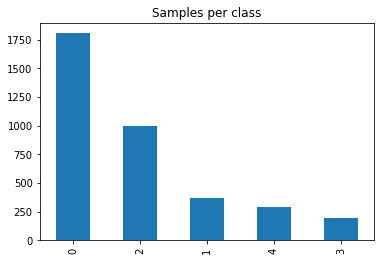

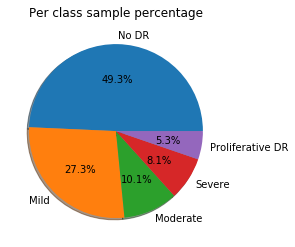

In [3]:
df = pd.read_csv('./blindness_data/train.csv')
plt_data = df.diagnosis.value_counts()
plt_data.plot(kind='bar', title = 'Samples per class', figsize = (6,4), align = 'center')
plt.show()

plt.pie(plt_data, autopct = '%1.1f%%', shadow=True, labels = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])
plt.title('Per class sample percentage')
plt.show()

# Show sample images

In [4]:
dir_path = './blindness_data/'
CLASSS = {0:"No DR", 1:"Mild", 2:"Moderate", 3:"Severe", 4:"Proliferative DR"}

def draw_img(imgs, target_dir, class_label='0'):
    fig, axis=plt.subplots(2,6, figsize=(15,6))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath=os.path.join(dir_path,f"{target_dir}/{row['id_code']}.png")
        img=cv2.imread(imgPath)
        row = idnx // 6
        col = idnx % 6
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis[row,col].imshow(img)
    plt.suptitle(class_label)
    plt.show()

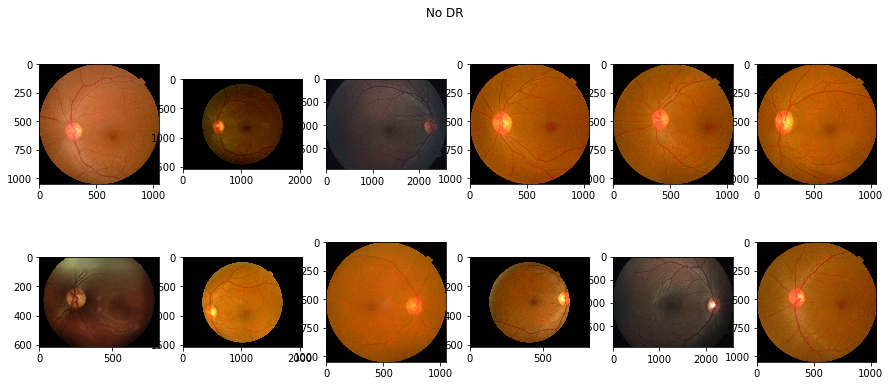

In [5]:
CLASS_ID=0
draw_img(df[df.diagnosis==CLASS_ID].head(12),'train_images', CLASSS[CLASS_ID])

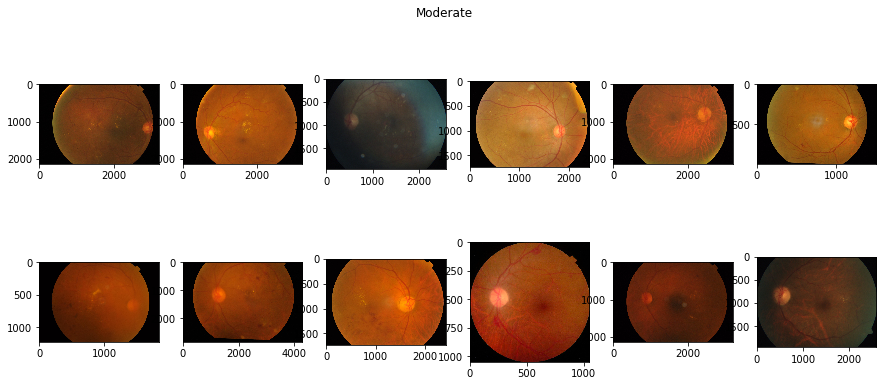

In [6]:
CLASS_ID=2
draw_img(df[df.diagnosis==CLASS_ID].head(12),'train_images', CLASSS[CLASS_ID])

# Train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=22)

In [8]:
print('X_train : ', X_train.shape)
print('y_train : ', y_train.shape)
print('X_test : ', X_test.shape)
print('y_test : ', y_test.shape)

X_train :  (2929, 224, 224, 3)
y_train :  (2929, 5)
X_test :  (733, 224, 224, 3)
y_test :  (733, 5)


# Plot train images

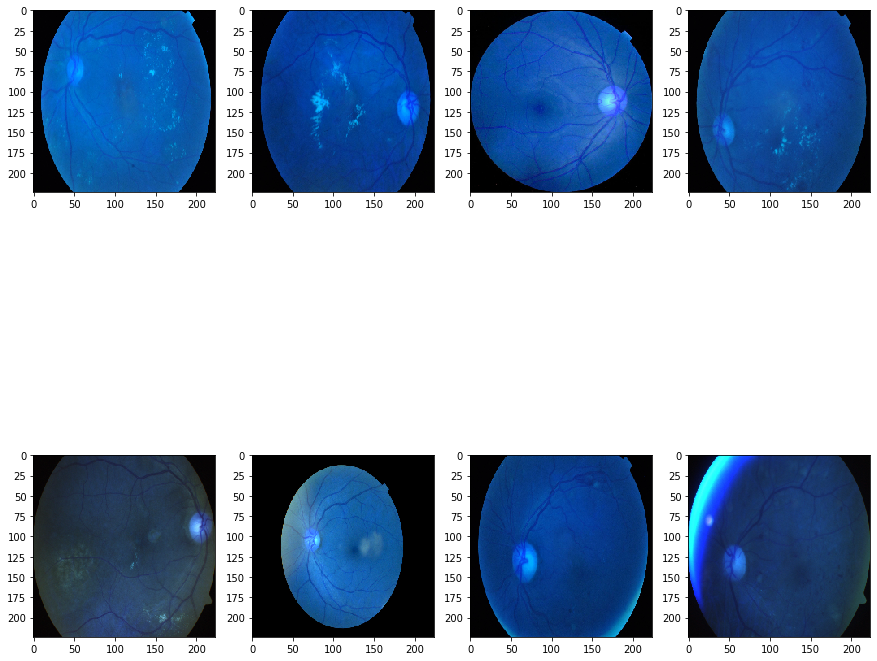

In [9]:
fig = plt.figure(figsize = (15,15))
for i in range(1, 9):
    img = X_train[i-1]
    fig.add_subplot(2,4,i)
    plt.imshow(img)

# Plot test images

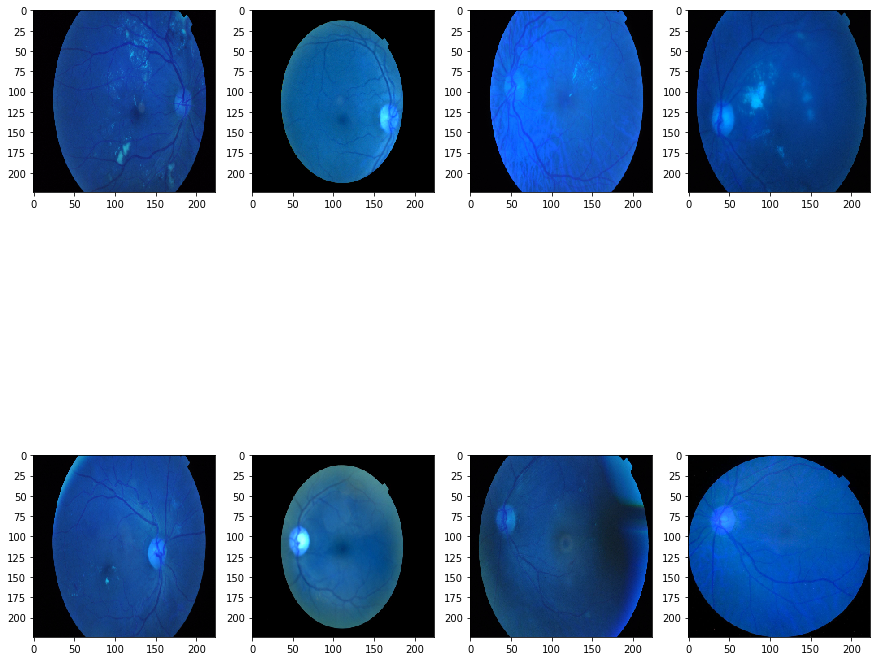

In [10]:
fig = plt.figure(figsize = (15,15))
for i in range(1, 9):
    img = X_test[i-1]
    fig.add_subplot(2,4,i)
    plt.imshow(img)

# Normalize the train test data

In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.
X_test = X_test / 255.

# Train test data generator

In [12]:
'''
train_data_gen = ImageDataGenerator(
    rotation_range = 15, 
    width_shift_range = 0.01,
    height_shift_range = 0.01,
    shear_range = 0.01,
    zoom_range = 0.08)
'''
train_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

train_generator = train_data_gen.flow(X_train, y_train, batch_size = 40)
test_generator = test_data_gen.flow(X_test, y_test, batch_size = 40)

# TensorBoard for Data

In [13]:
tensorboard = TensorBoard(log_dir='./Log', histogram_freq = 0, write_graph = True, write_images = True)

# Create VGG16 Model

In [16]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_height, image_width, channel), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

W0803 17:28:14.823470 139849469011776 deprecation_wrapper.py:119] From /home/dl-box/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 17:28:14.834257 139849469011776 deprecation_wrapper.py:119] From /home/dl-box/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 17:28:14.843133 139849469011776 deprecation_wrapper.py:119] From /home/dl-box/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 17:28:14.873721 139849469011776 deprecation_wrapper.py:119] From /home/dl-box/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0803 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

# Save the model

In [17]:
# Save our model using specified conditions
checkpoint = ModelCheckpoint("vgg_blindness_detection.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

# Configure the model for training

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0803 17:28:20.735461 139849469011776 deprecation_wrapper.py:119] From /home/dl-box/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0803 17:28:20.763899 139849469011776 deprecation_wrapper.py:119] From /home/dl-box/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



# Fit the model on the data provided

In [19]:
epochs = 50
batch_size = 30
steps_per_epoch = len(X_train) / batch_size
validation_steps = len(X_test) / batch_size

model_details = model.fit_generator(train_generator,
                                    epochs = epochs,
                                    steps_per_epoch = steps_per_epoch,
                                    validation_data = test_generator,
                                    validation_steps = validation_steps,
                                    callbacks = [checkpoint, tensorboard],
                                    verbose = 1)

W0803 17:28:23.782559 139849469011776 deprecation.py:323] From /home/dl-box/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0803 17:28:27.479790 139849469011776 deprecation_wrapper.py:119] From /home/dl-box/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0803 17:28:27.480790 139849469011776 deprecation_wrapper.py:119] From /home/dl-box/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/50
98/97 [==============================] - 1351s 14s/step - loss: 1.3502 - acc: 0.4830 - val_loss: 1.3266 - val_acc: 0.4728

Epoch 00001: val_acc improved from -inf to 0.47276, saving model to vgg_blindness_detection.h5
Epoch 2/50
98/97 [==============================] - 1316s 13s/step - loss: 1.3030 - acc: 0.4904 - val_loss: 1.3123 - val_acc: 0.4697

Epoch 00002: val_acc did not improve from 0.47276
Epoch 3/50
98/97 [==============================] - 1311s 13s/step - loss: 1.2975 - acc: 0.4971 - val_loss: 1.2919 - val_acc: 0.4943

Epoch 00003: val_acc improved from 0.47276 to 0.49435, saving model to vgg_blindness_detection.h5
Epoch 4/50
98/97 [==============================] - 1294s 13s/step - loss: 1.2882 - acc: 0.5005 - val_loss: 1.3187 - val_acc: 0.4704

Epoch 00004: val_acc did not improve from 0.49435
Epoch 5/50
98/97 [==============================] - 1304s 13s/step - loss: 1.3024 - acc: 0.4980 - val_loss: 1.2917 - val_acc: 0.4933

Epoch 00005: val_acc did not improve 

98/97 [==============================] - 1300s 13s/step - loss: 1.2843 - acc: 0.5026 - val_loss: 1.3085 - val_acc: 0.4799

Epoch 00045: val_acc did not improve from 0.49435
Epoch 46/50
98/97 [==============================] - 1302s 13s/step - loss: 1.2922 - acc: 0.4951 - val_loss: 1.2994 - val_acc: 0.4830

Epoch 00046: val_acc did not improve from 0.49435
Epoch 47/50
98/97 [==============================] - 1292s 13s/step - loss: 1.3002 - acc: 0.4945 - val_loss: 1.3230 - val_acc: 0.4676

Epoch 00047: val_acc did not improve from 0.49435
Epoch 48/50
98/97 [==============================] - 1299s 13s/step - loss: 1.2869 - acc: 0.4938 - val_loss: 1.2961 - val_acc: 0.4810

Epoch 00048: val_acc did not improve from 0.49435
Epoch 49/50
98/97 [==============================] - 1301s 13s/step - loss: 1.3026 - acc: 0.4945 - val_loss: 1.2974 - val_acc: 0.4882

Epoch 00049: val_acc did not improve from 0.49435
Epoch 50/50
98/97 [==============================] - 1292s 13s/step - loss: 1.2956 - ac

# Plotting Model accuracy and loss

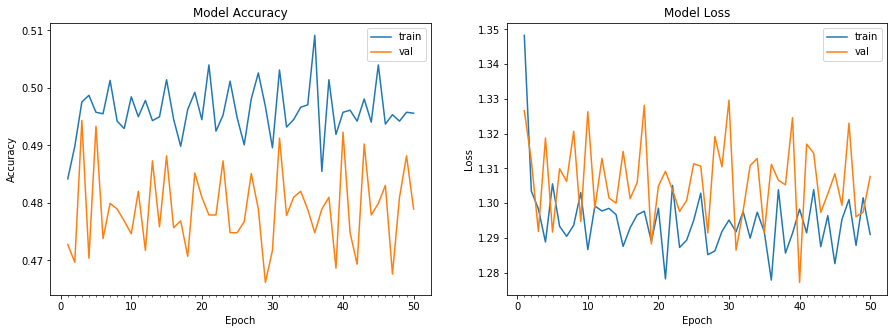

In [21]:
# Create sub-plots
fig, axs = plt.subplots(1,2, figsize=(15,5))

# Summarize history for accuracy
axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
axs[0].legend(['train', 'val'], loc='best')

# Summarize history for loss
axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
axs[1].legend(['train', 'val'], loc='best')

# Show the plot
plt.show()

# Confusion Matrix

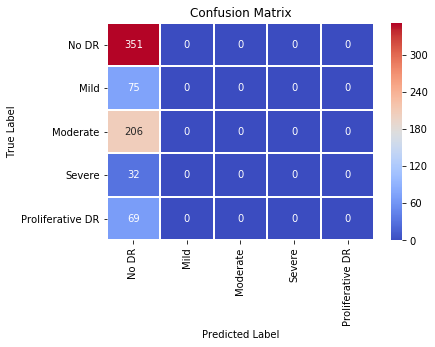

In [22]:
# confusion matrix
LABELS = ['No DR',
          'Mild',
          'Moderate',
          'Severe',
          'Proliferative DR']
y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
fmt = 'd'
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap='coolwarm',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt=fmt)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()